Transfer Learning Notebook 

Martin Jasinski
2025

In [22]:
import torch
import torch.nn as nn
import torchvision

import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns


In [2]:
# -------------------------------------------------------------------------------
# Import ResNet from scratch
# -------------------------------------------------------------------------------

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [34]:
# -------------------------------------------------------------------------------
# Create manual training
# -------------------------------------------------------------------------------

# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 (adjust as needed)
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Define dataset directory
train_dir = "Dataset_1/Train"  # Training Dataset
test_dir = "Dataset_2/Test"    # Test Dataset

# Load dataset using ImageFolder (assumes subfolders are class labels)
# Applied a generic transform
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# check if the dataset is properly imported
# lists the class indicies and the number of items
print("Class-to-index mapping:", train_dataset.class_to_idx)
print("Number of images in dataset:", len(train_dataset))


Class-to-index mapping: {'BRCA': 0, 'GBM': 1}
Number of images in dataset: 1000


In [ ]:
# -------------------------------------------------------------------------------
# Training Loop
# -------------------------------------------------------------------------------

# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cuda_id = torch.cuda.current_device()
print(f"Using device: {torch.cuda.get_device_name(cuda_id)}")

# Load the model and move it to GPU
model = ResNet18().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Define DataLoader ( random set of training from the training set )
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

loss_total = []
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch} loss: {running_loss / len(trainloader)}')
    loss_total.append(running_loss / len(trainloader))

Using device: NVIDIA GeForce RTX 2070
Epoch 0 loss: 0.5100789018033538
Epoch 1 loss: 0.08774028791231103
Epoch 2 loss: 0.06590676109772176
Epoch 3 loss: 0.07946724348585121
Epoch 4 loss: 0.05772005702601746
Epoch 5 loss: 0.06731119912001304
Epoch 6 loss: 0.03826586034119828
Epoch 7 loss: 0.022292629655566998
Epoch 8 loss: 0.024005567669519223
Epoch 9 loss: 0.012711178429526626


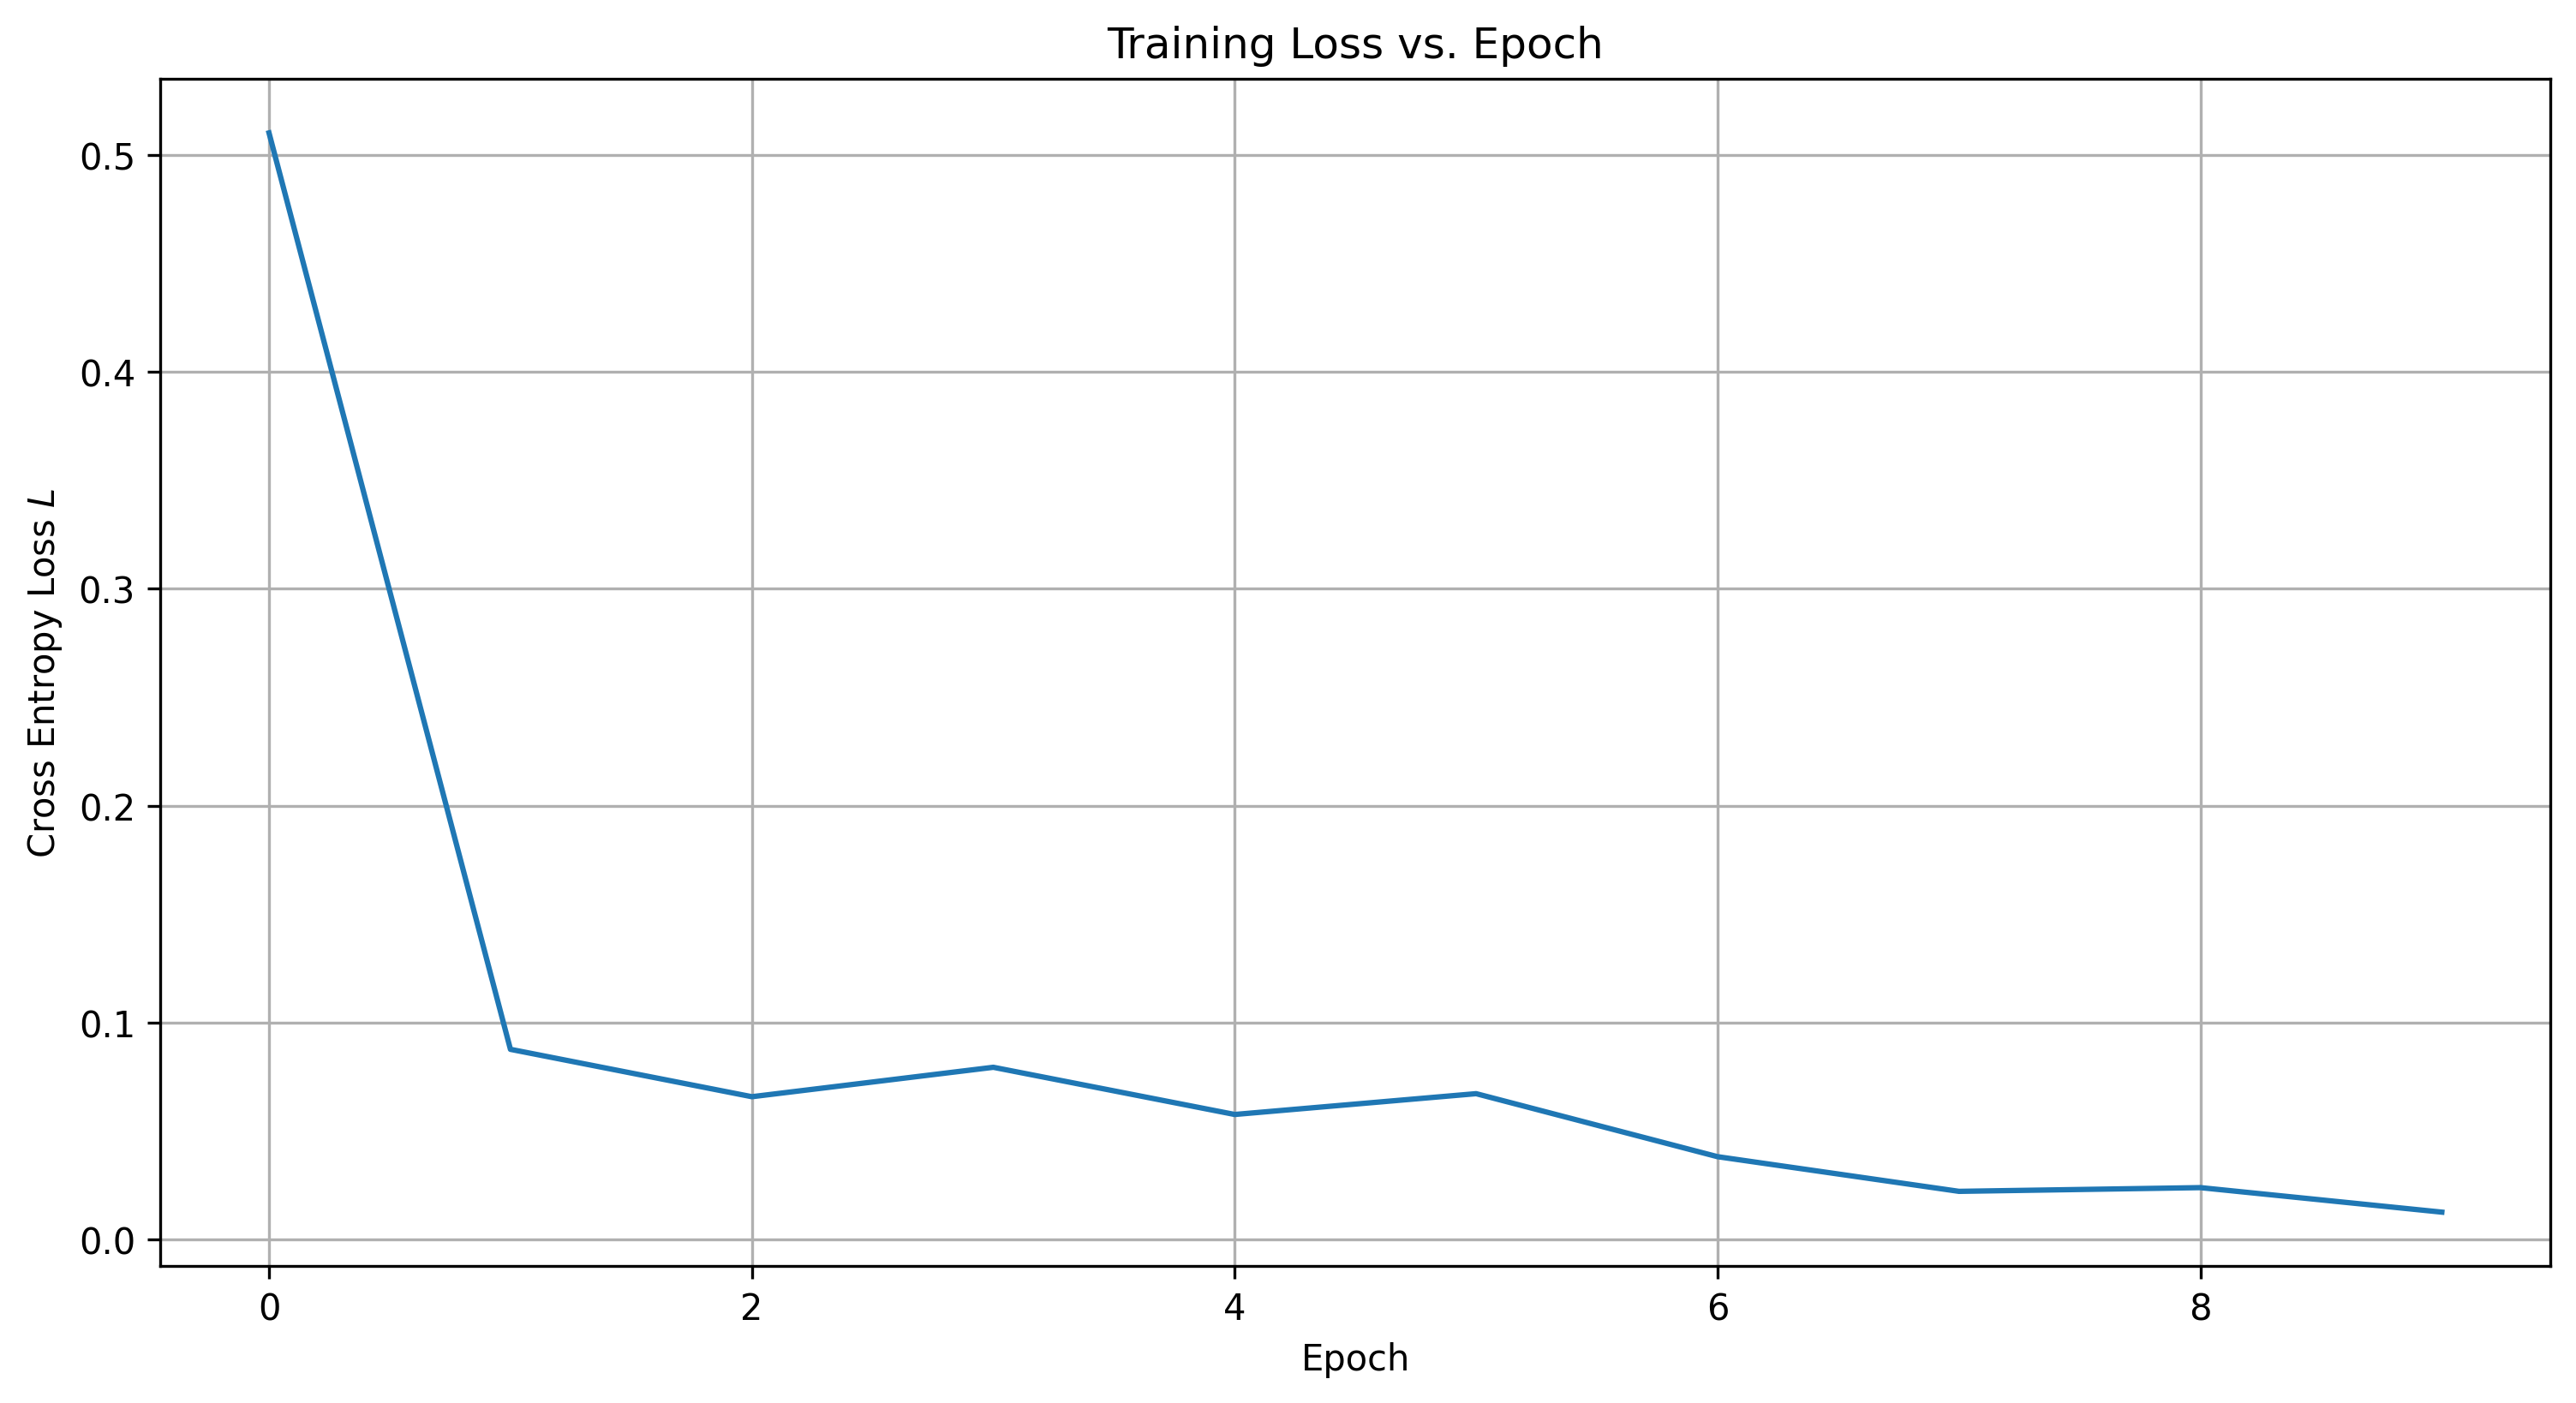

In [32]:
# -------------------------------------------------------------------------------
# Plot the final resulting loss
# -------------------------------------------------------------------------------

fig = plt.figure(figsize = (12,6), dpi=300)
ax = fig.add_subplot(111)
ax.plot(np.arange(0,10,1), loss_total, label="Running Loss")
ax.set_title("Training Loss vs. Epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("Cross Entropy Loss $L$")
ax.grid()
plt.show()

In [35]:
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

print("Class-to-index mapping:", test_dataset.class_to_idx)
print("Number of images in dataset:", len(test_dataset))

# Set model to evaluation mode
model.eval()

# Initialize tracking variables
total_loss, correct, total = 0.0, 0, 0
all_labels = []
all_predictions = []
all_probs = []

with torch.no_grad():  # Disable gradient computation for efficiency
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Store loss
        total_loss += loss.item()

        # Predictions
        probabilities = F.softmax(outputs, dim=1)  # Convert logits to probabilities
        _, predicted = torch.max(outputs, 1)

        # Store results for evaluation
        all_labels.extend(labels.cpu().numpy())  # Convert to NumPy
        all_predictions.extend(predicted.cpu().numpy())
        all_probs.extend(probabilities.cpu().numpy())

        # Compute accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Compute final loss and accuracy
avg_loss = total_loss / len(testloader)
accuracy = correct / total * 100


Class-to-index mapping: {'LUAD': 0, 'LUSC': 1}
Number of images in dataset: 100



Model Evaluation Results:
Loss: 1.0705, Accuracy: 69.00%

Classification Report:
              precision    recall  f1-score   support

        LUAD       0.77      0.54      0.64        50
        LUSC       0.65      0.84      0.73        50

    accuracy                           0.69       100
   macro avg       0.71      0.69      0.68       100
weighted avg       0.71      0.69      0.68       100



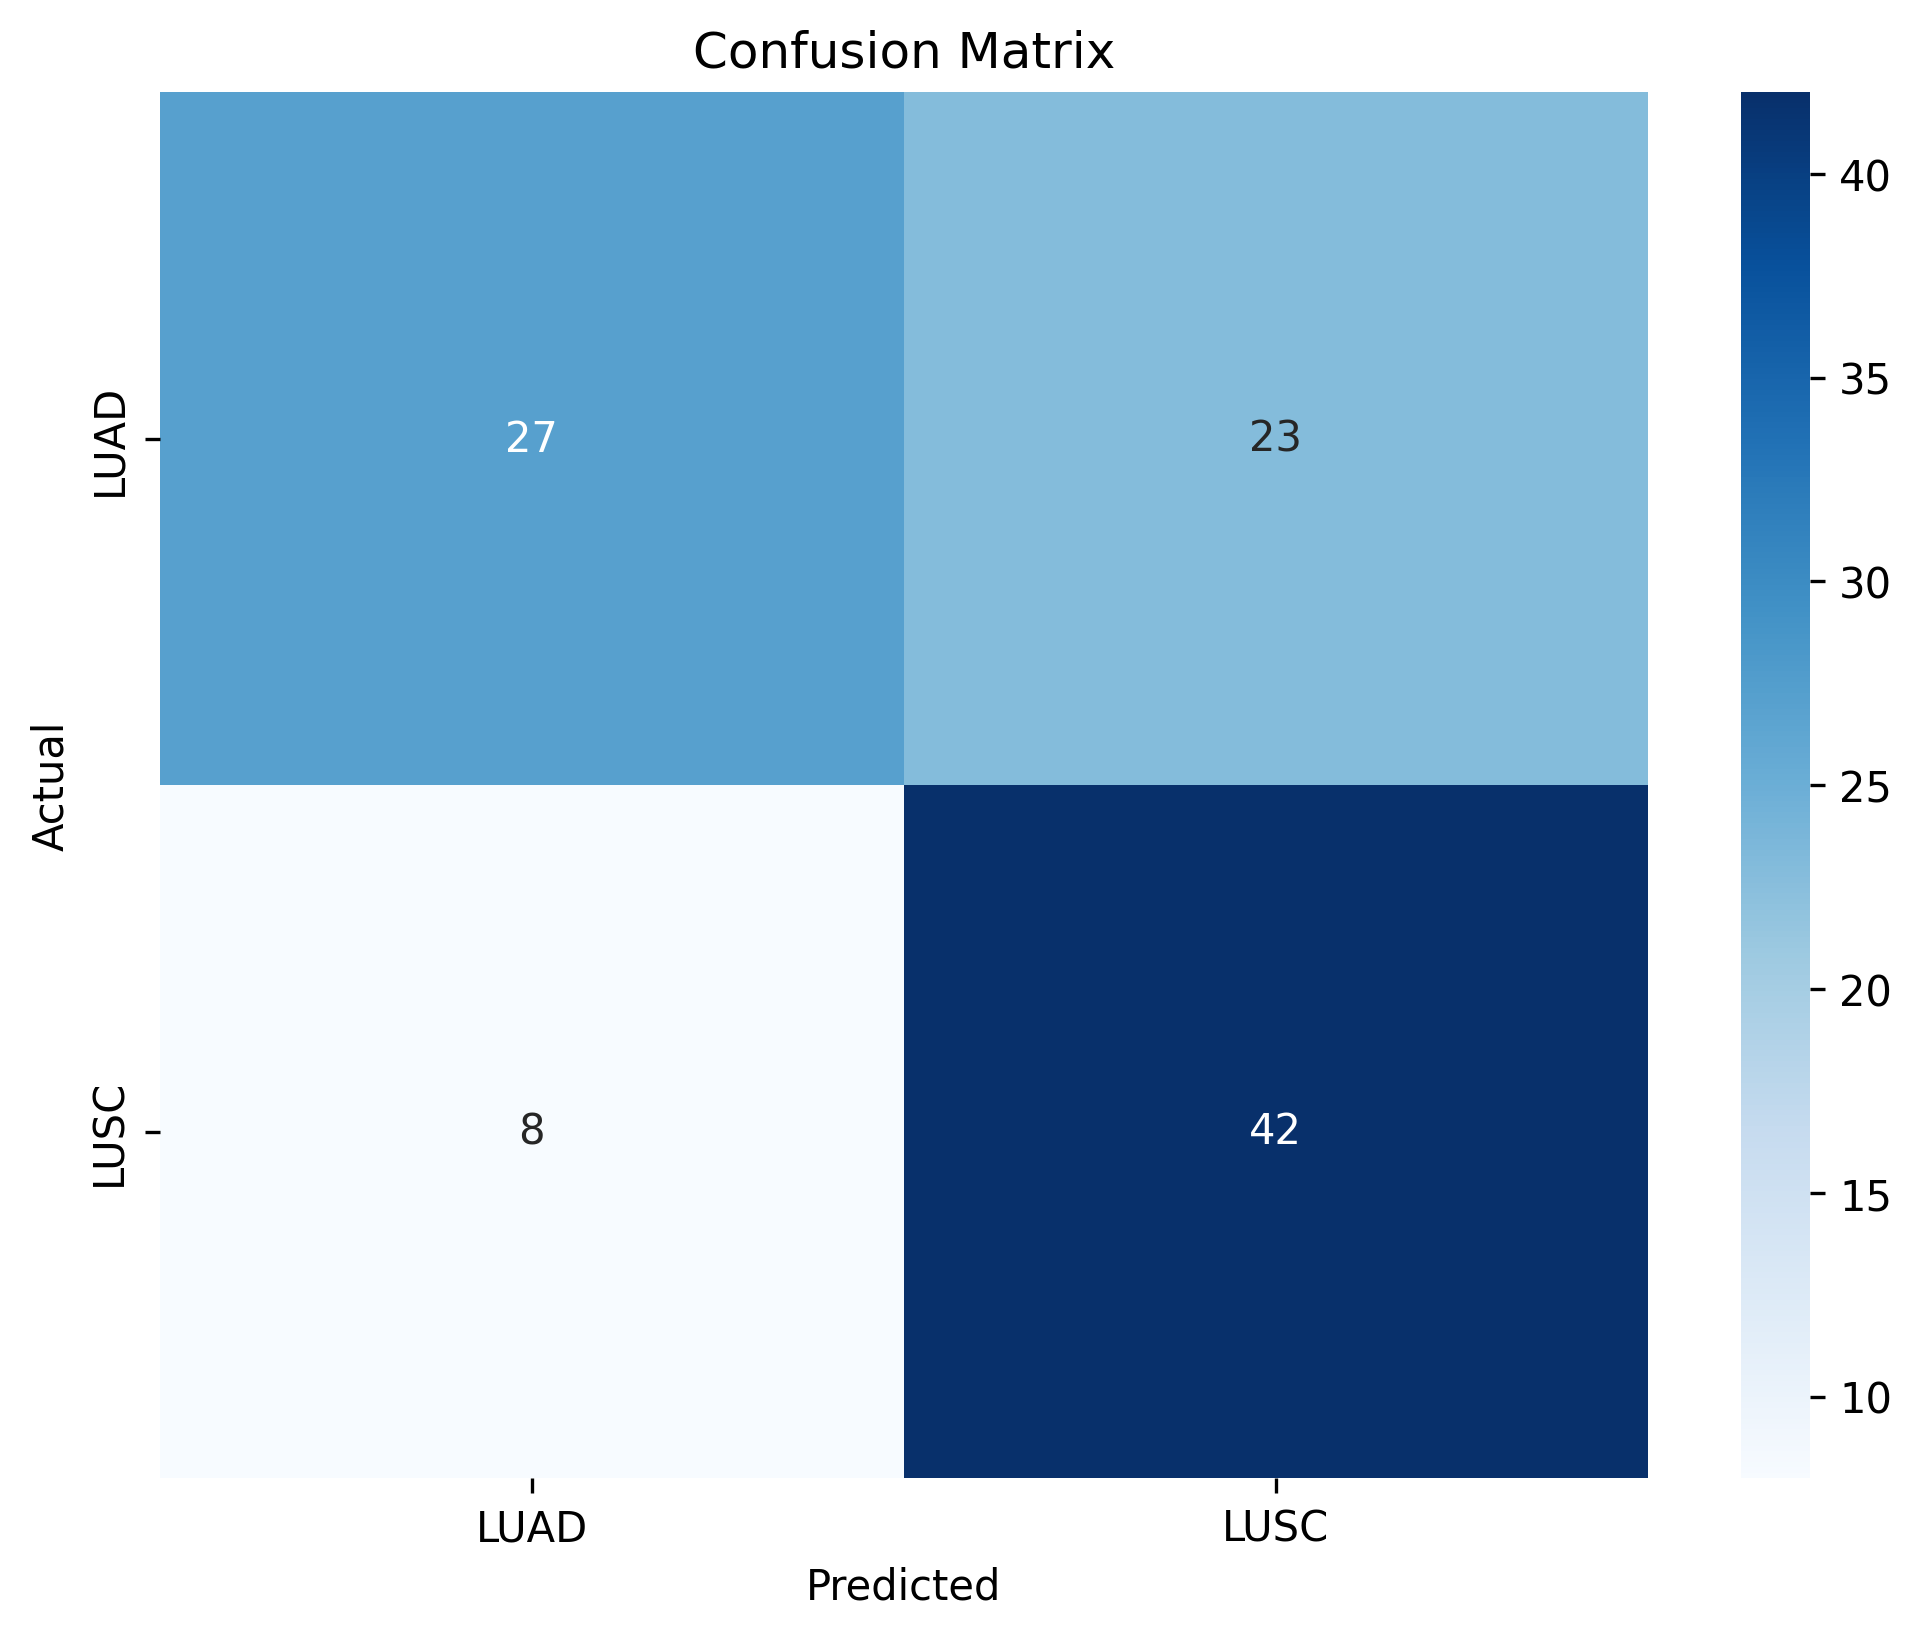

In [36]:
print(f"\nModel Evaluation Results:")
print(f"Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Get class names
class_names = list(test_dataset.class_to_idx.keys())

# Generate Precision, Recall, F1-score
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=class_names))

# Compute Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6), dpi=300)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Compute ROC Curve and AUC 
if len(class_names) > 2:
    plt.figure(figsize=(8, 6))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(np.array(all_labels) == i, np.array(all_probs)[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {class_name} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--")  # Diagonal line for random guess
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()